In [ ]:
"""
Use all variables (continuous, categorical) as features
Use X_adasyn and y_adasyn as train data (imbalanced classes handled)

Refine models:

1. Logistic Regression
    - Grid search CV: solver, penalty, C
    - Adjust threshold: compared to baseline model with 0.41 precision, recall has improved from 61% to 82%!
    
2. kNN
    - Feature engineering
    - Tune hyperparameters (grid search)
    
3. Naive Bayes
    - Higher recall but lower precision.


Conclusion:
ROC AUC highest - Logistic regression
Recall highest - Naive Bayes (65%)

"""

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
# Load data
# All variables (continuous + categorical)
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')


X_train = pd.read_pickle('../dump/X_adasyn')
y_train = pd.read_pickle('../dump/y_adasyn')
X_test = pd.read_pickle('../dump/X_test_processed')
y_test = df_test['target']

In [5]:
df_train.shape, X_train.shape

((19158, 14), (28836, 32))

In [204]:
Counter(y_train)

Counter({1: 14455, 0: 14381})

In [6]:
X_train.iloc[:,:4]

,city_development_index,training_hours,experience,last_new_job
0,0.738919,-0.488985,1.793483,-0.588135
1,-0.428410,-0.305825,0.530812,1.816493
2,-1.660590,0.293607,-0.731859,-1.189292
3,-0.323026,-0.222571,-1.300061,-1.189292
4,-0.501368,-0.955209,1.793483,1.215336
...,...,...,...,...
28831,0.316702,-0.564869,-0.473409,-0.588135
28832,0.472487,-0.425288,0.459461,-0.588135
28833,0.770312,-0.283658,0.430281,1.337864
28834,0.738919,-0.152315,0.445527,1.410450


### 1. Logistic Regression

In [16]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
# print('intercept: ', round(lm.intercept_[0], 4))
# pd.DataFrame(list(zip(cat_variables,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
# .sort_values('Coef',ascending=False)

LogisticRegression(C=100000, solver='newton-cg')

In [17]:
# Coefficient for top features

feature = X_train.columns
coef = pd.DataFrame(list(zip((feature),lm.coef_[0])),columns = ['Feature','Coefficient']).\
sort_values(['Coefficient'],ascending=False)
top_feature = coef.head(10)
top_feature

,Feature,Coefficient
31,company_type_unknown,0.846069
29,company_type_Public Sector,0.370853
18,major_discipline_unknown,0.337272
28,company_type_Other,0.200578
4,relevent_experience_No relevent experience,0.163685
3,last_new_job,0.122986
30,company_type_Pvt Ltd,-0.014111
17,major_discipline_STEM,-0.037752
1,training_hours,-0.057605
22,company_size_50-99,-0.067487


In [18]:
bottom_feature = coef.tail(10)
bottom_feature

,Feature,Coefficient
24,company_size_5000-9999,-0.480315
25,company_size_<10,-0.498822
15,major_discipline_No Major,-0.499350
16,major_discipline_Other,-0.506544
23,company_size_500-999,-0.535622
0,city_development_index,-0.559493
7,enrolled_university_unknown,-0.603623
8,education_level_High School,-1.181321
12,education_level_unknown,-1.191776
11,education_level_Primary School,-1.815606


In [19]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1098,455
Changing (1),149,427


In [20]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.7162987317989666 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.88      0.71      0.78      1553
           1       0.48      0.74      0.59       576

    accuracy                           0.72      2129
   macro avg       0.68      0.72      0.69      2129
weighted avg       0.77      0.72      0.73      2129



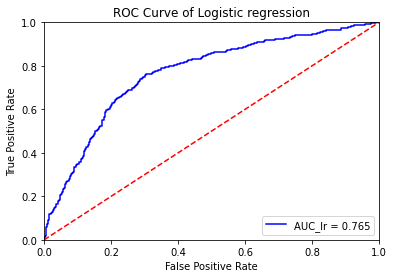

In [12]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic regression')
plt.show()

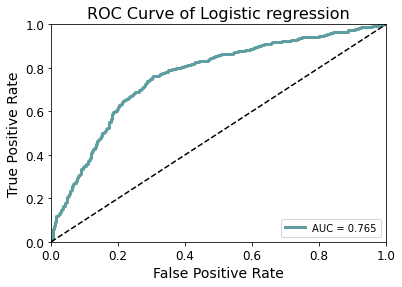

In [108]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)


fig, ax = plt.subplots()

plt.plot(fpr, tpr, 'cadetblue', linewidth=3, label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.title('ROC Curve of Logistic regression',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

fig.savefig('../plot/ROC_lr_1.pdf', bbox_inches='tight', transparent=True)

In [125]:
roc_df = pd.DataFrame(roc_curve(y_test, y_scores[:, 1])).transpose()
roc_df.columns=['fpr','tpr','threshold']
roc_df.to_csv('../dump/roc_df_lr.csv')

In [124]:
roc_df

,fpr,tpr,threshold
0,0.000000,0.000000,1.936079
1,0.000000,0.001736,0.936079
2,0.000644,0.001736,0.927732
3,0.000644,0.006944,0.920744
4,0.001288,0.006944,0.920591
...,...,...,...
681,0.983258,0.994792,0.151156
682,0.983258,0.996528,0.150794
683,0.990341,0.996528,0.134558
684,0.990341,1.000000,0.132303


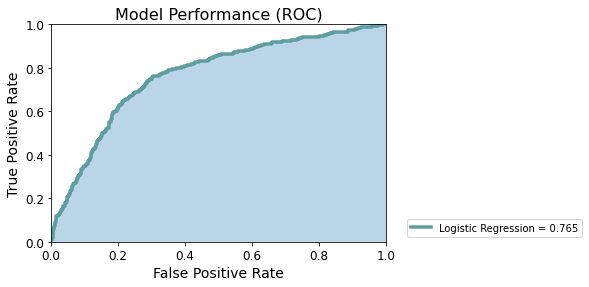

In [31]:
fig, ax = plt.subplots()

# pd.DataFrame(tpr,fpr).plot.area(alpha=0.4)
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.stackplot(fpr, tpr,alpha=0.3)
plt.plot(fpr, tpr, 'cadetblue', linewidth=3.5, label = 'Logistic Regression = %0.3f' % roc_auc)
# plt.plot([0, 1], [0, 1],'k--',label = 'Random guess = 0.5')

plt.legend(loc = 'lower right',bbox_to_anchor=(1.6, 0))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.title('Model Performance (ROC)',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

fig.savefig('../plot/ROC_lr_2.pdf', bbox_inches='tight', transparent=True)

In [125]:
df = df_test
df = df.reset_index()
prob_df = pd.DataFrame(lm.predict_proba(X_test)).apply(lambda x:round(x,3)*100)

df = pd.concat([df,prob_df],axis=1)[['enrollee_id','experience',1,'target']]
df.columns=['Enrollee_id','experience','Probability (%)','Target']
df = df.sort_values('Probability (%)',ascending=False).reset_index()

# Save as csv file
df.to_csv('../dump/candidate_proba.csv')
df

,index,Enrollee_id,experience,Probability (%),Target
0,649,22527,4.0,93.6,1
1,1597,32795,3.0,92.8,0
2,918,26694,2.0,92.5,1
3,1890,31758,1.0,92.4,1
4,1060,7626,3.0,92.1,0
...,...,...,...,...,...
2124,177,20977,25.0,11.1,0
2125,2012,29908,15.0,10.5,0
2126,1421,29417,25.0,10.3,0
2127,232,8818,7.0,9.2,0


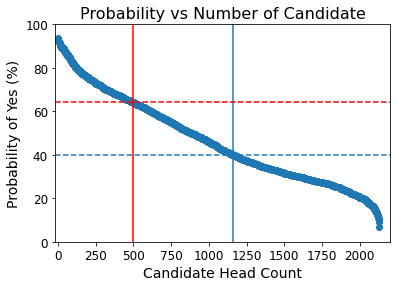

In [157]:
def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx

probability=40
i = find_nearest(df['Probability (%)'], probability)

fig, ax = plt.subplots()
plt.scatter(x=df.index, y=(df['Probability (%)']))

plt.axvline(x=i)
plt.axhline(y=probability,linestyle='--')

input_number_of_candidate=500
plt.axvline(x=input_number_of_candidate,color='r')
plt.axhline(y=df.iloc[input_number_of_candidate]['Probability (%)'],linestyle='--',color='r')

plt.xlim([-20,2200])
plt.ylim([0,100])
plt.ylabel('Probability of Yes (%)',fontsize=14)
plt.xlabel('Candidate Head Count',fontsize=14)
plt.title('Probability vs Number of Candidate',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [217]:
df_train

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,25.0,50-99,unknown,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,5,47,0
2,11561,city_21,0.624,unknown,No relevent experience,Full time course,Graduate,STEM,5.0,50-99,unknown,0,83,0
3,33241,city_115,0.789,unknown,No relevent experience,unknown,Graduate,Business Degree,0.5,50-99,Pvt Ltd,0,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,25.0,50-99,Funded Startup,4,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14.0,50-99,unknown,1,42,1
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14.0,50-99,unknown,4,52,1
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,25.0,50-99,Pvt Ltd,4,44,0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,unknown,0.5,500-999,Pvt Ltd,2,97,0


#### Grid search cross-validation
Logistic regression does not really have hyperparameters to tune.
* **solver** : ‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’
* **penalty** (regularization) : ‘none’, ‘l1’, ‘l2’, ‘elasticnet’
* **C** (penalty strength) : 100, 10, 1.0, 0.1, 0.01

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [35]:
lm_2=LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100000000, 10000, 1000, 100, 1.0, 0.1, 0.01]
# c_values = [1.5, 1.2, 0.8, 0.4, 0.2]

In [36]:
# Define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=lm_2, param_grid=grid, n_jobs=-1, cv=5,\
                           scoring='precision',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [37]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.688547 using {'C': 100000000, 'penalty': 'l2', 'solver': 'liblinear'}


In [38]:
lm_2 = grid_search.best_estimator_
# LogisticRegression(solver='lbfgs', C=10000, penalty='l2')
lm_2.fit(X_train,y_train)
y_predict = lm_2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1098,455
Changing (1),149,427


In [39]:
print('Accuracy score:',accuracy_score(y_test,y_predict))
print('ROC AUC score:',roc_auc_score(y_test,lm_2.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.7162987317989666
ROC AUC score: 0.7651666577234028 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.88      0.71      0.78      1553
           1       0.48      0.74      0.59       576

    accuracy                           0.72      2129
   macro avg       0.68      0.72      0.69      2129
weighted avg       0.77      0.72      0.73      2129



In [40]:
# Precision and recall for (1) both improved 0.01...

#### Cross-validation

In [41]:
from sklearn.model_selection import cross_val_score

In [42]:
recalls = cross_val_score(lm_2, X_train, y_train, cv=5, scoring='recall')

In [43]:
print('Mean:', np.mean(recalls))
print('All recalls:', (recalls))

Mean: 0.67616741611899
All recalls: [0.76271186 0.72154964 0.62850225 0.62193013 0.6461432 ]


### * Adjust threshold

In [44]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Looking', 'Looking'],
           yticklabels=['Not Looking', 'Looking']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [45]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm_2, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [96]:
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
len(threshold)
threshold[0],threshold[685]

(1.9360790704535549, 0.06596623970876746)

In [111]:
value=0.2
def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
i = find_nearest(threshold, value)

(670, 0.2029778753939861)

In [160]:
def roc_threshold(lm,threshold):
    y_scores = lm.predict_proba(X_test)
    fpr, tpr, threshold_array = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
    i = find_nearest(threshold_array, threshold)
    
    fig, ax = plt.subplots()
    

    # pd.DataFrame(tpr,fpr).plot.area(alpha=0.4)
    plt.stackplot(fpr, tpr,alpha=0.3)
    plt.plot(fpr, tpr, 'cadetblue', linewidth=3.5, label = 'Logistic Regression')
    plt.plot([0, 1], [0, 1],'k--',linewidth=1, label = 'Random Guess')
    plt.scatter(fpr[i], tpr[i],linewidth=3,color='orange',zorder=10)
    ax.annotate('Threshold= %.2f' % (threshold_array[i]),[fpr[i]+0.03,tpr[i]-0.02])

    plt.legend(loc = 'lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.title('Model Performance (ROC)',fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);

In [161]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: roc_threshold(lm_2, threshold), threshold=(0,1,0.2))

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.2), Output()), _dom_clas…

In [162]:
threshold = 0.4
y_predict = (lm_2.predict_proba(X_test)[:, 1] >= threshold)
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.90      0.56      0.69      1553
           1       0.41      0.83      0.55       576

    accuracy                           0.63      2129
   macro avg       0.66      0.70      0.62      2129
weighted avg       0.77      0.63      0.65      2129



In [186]:
# Use recall to find threshold
threshold_list = [x/100 for x in range(0,100)]
print(threshold_list)
recall_list=[]
for value in threshold_list:
    threshold = value
    y_predict = (lm_2.predict_proba(X_test)[:, 1] >= threshold)
    recall_list.append(recall_score(y_test,y_predict))
recall_list

i = find_nearest(recall_list, 0.8)

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


(44, 0.7986111111111112)

In [47]:
# LogisticRegression(solver='lbfgs', C=10000, penalty='l2')
lm_2.fit(X_train,y_train)
y_predict = (lm_2.predict_proba(X_test)[:, 1] >= threshold)
predict_df = pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])
predict_df = predict_df.append(predict_df.sum(numeric_only=True), ignore_index=True)
predict_df.index=['Not changing (0)','Changing (1)','Total']
predict_df

,Predict-not changing (0),Predict-change (1)
Not changing (0),873,680
Changing (1),99,477
Total,972,1157


In [48]:
# Classification report on train data
threshold = 0.3
y_predict = (lm_2.predict_proba(X_train)[:, 1] >= threshold)
print('Classification report (Logistic regression):\n\n',classification_report(y_train,y_predict))

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.76      0.29      0.42     14381
           1       0.56      0.91      0.70     14455

    accuracy                           0.60     28836
   macro avg       0.66      0.60      0.56     28836
weighted avg       0.66      0.60      0.56     28836



In [49]:
# LogisticRegression(solver='lbfgs', C=10000, penalty='l2')
lm_2.fit(X_train,y_train)
y_predict = lm_2.predict(X_train)
predict_df = pd.DataFrame(confusion_matrix(y_train, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])
predict_df = predict_df.append(predict_df.sum(numeric_only=True), ignore_index=True)
predict_df.index=['Not changing (0)','Changing (1)','Total']
predict_df

,Predict-not changing (0),Predict-change (1)
Not changing (0),10001,4380
Changing (1),4667,9788
Total,14668,14168


In [ ]:
# Compared to baseline Logistic regression model with 0.41 precision, recall has improved from 0.61 to 0.82!

### * Feature Engineering

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [ ]:
X_train['training_hours_experience'] = X_train['training_hours'] * X_train['experience']
X_test['training_hours_experience'] = X_test['training_hours'] * X_test['experience']

X_train['last_job_experience'] = X_train['experience'] / X_train['last_new_job']
X_test['last_job_experience'] = X_test['experience'] / X_test['last_new_job']

X_train['last_job_city'] = X_train['last_new_job'] * X_train['city_development_index']
X_test['last_job_city'] = X_test['last_new_job'] * X_test['city_development_index']

X_train['training_hours_city'] = X_train['training_hours'] * X_train['city_development_index']
X_test['training_hours_city'] = X_test['training_hours'] * X_test['city_development_index']

In [ ]:
X_train['last_job_experience'] = scaler.fit_transform(X_train[['last_job_experience']])

In [ ]:
X_train

In [ ]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

In [ ]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

In [ ]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

In [ ]:
lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

In [ ]:
# Interaction terms do not improve the model

### 2. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train,y_train)
pred = knn_3.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=3):\n\n',classification_report(y_test,pred))

In [ ]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train,y_train)
pred = knn_5.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=5):\n\n',classification_report(y_test,pred))

In [ ]:
# knn (n=3)
y_scores = knn_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_knn3 = %0.3f' % roc_auc)

# knn (n=5)
y_scores = knn_5.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'g', label = 'AUC_knn5 = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

### 3. Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)
pred = nb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

In [ ]:
# Naive Bayes ROC curve
y_scores = nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_nb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Naive Bayes')
plt.show()

In [ ]:
# Compared to baseline version, Naive Bayes has higher recall but lower precision.